# Chapter 17 - Representational Learning and Generative Learning using Autoencoders and GANs

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [2]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dongdongdongdong/anaconda3/lib/python3.6/s

In [3]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale 28x28 image:

In [4]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

## PCA with a linear Autoencoder

Build a 3D dataset:

In [7]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

In [8]:
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Now let's build the Autoencoder:

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
encoder = keras.models.Sequential([
    keras.layers.Dense(2, input_shape=[3])
])

In [11]:
decoder = keras.models.Sequential([
    keras.layers.Dense(3, input_shape=[2])
])

In [12]:
autoencoder = keras.models.Sequential([encoder, decoder])

In [13]:
autoencoder.compile(loss='mse',
                    optimizer=keras.optimizers.SGD(lr=1.5))

In [14]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
60/60 [==============================] - 0s 1ms/sample - loss: 0.2648
Epoch 2/20
60/60 [==============================] - 0s 74us/sample - loss: 0.1317
Epoch 3/20
60/60 [==============================] - 0s 75us/sample - loss: 0.0778
Epoch 4/20
60/60 [==============================] - 0s 78us/sample - loss: 0.0655
Epoch 5/20
60/60 [==============================] - 0s 110us/sample - loss: 0.0748
Epoch 6/20
60/60 [==============================] - 0s 109us/sample - loss: 0.1039
Epoch 7/20
60/60 [==============================] - 0s 119us/sample - loss: 0.1262
Epoch 8/20
60/60 [==============================] - 0s 108us/sample - loss: 0.0536
Epoch 9/20
60/60 [==============================] - 0s 112us/sample - loss: 0.0208
Epoch 10/20
60/60 [==============================] - 0s 118us/sample - loss: 0.0146
Epoch 11/20
60/60 [==============================] - 0s 176us/sample - loss: 0.0097
Epoch 12/20
60/60 [==============================] - 0s 118us/sample - loss: 0.0076
Epoch 

In [17]:
codings = encoder.predict(X_train)

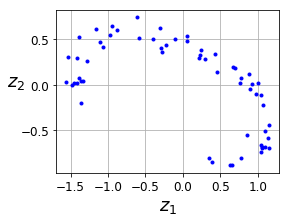

In [18]:
fig = plt.figure(figsize=(4, 3))

plt.plot(codings[:, 0], codings[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)

plt.show()

## Stacked Autoencoders

Let's use MNIST:

In [20]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### Train all layers at once:

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders):

In [21]:
def rounder_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [22]:
tf.random.set_seed(42)
np.random.seed(42)

In [23]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

In [24]:
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [25]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [26]:
stacked_ae.compile(loss='binary_crossentropy',
                   optimizer=keras.optimizers.SGD(lr=1.5),
                   metrics=[rounder_accuracy])

In [27]:
history = stacked_ae.fit(X_train, X_train,
                         epochs=20,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3386 - rounder_accuracy: 0.8866 - val_loss: 0.3118 - val_rounder_accuracy: 0.9128
Epoch 2/20
55000/55000 [==============================] - 4s 66us/sample - loss: 0.3055 - rounder_accuracy: 0.9153 - val_loss: 0.3030 - val_rounder_accuracy: 0.9200
Epoch 3/20
55000/55000 [==============================] - 4s 66us/sample - loss: 0.2986 - rounder_accuracy: 0.9214 - val_loss: 0.2982 - val_rounder_accuracy: 0.9249
Epoch 4/20
55000/55000 [==============================] - 4s 67us/sample - loss: 0.2946 - rounder_accuracy: 0.9251 - val_loss: 0.2938 - val_rounder_accuracy: 0.9284
Epoch 5/20
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2921 - rounder_accuracy: 0.9273 - val_loss: 0.2922 - val_rounder_accuracy: 0.9302
Epoch 6/20
55000/55000 [==============================] - 4s 69us/sample - loss: 0.2904 - rounder_accuracy: 0.9289 - val_loss:

### Visualizing the Reconstructions:

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [29]:
def show_recons(model, images=X_valid, n_images=5):
    recons = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(recons[image_index])

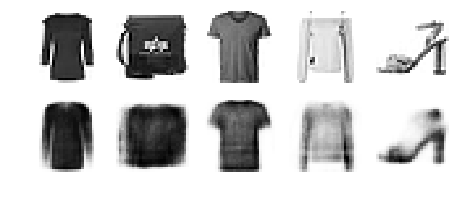

In [30]:
show_recons(stacked_ae)

## Visualizing the Fashion MNIST Dataset

In [31]:
np.random.seed(42)

In [32]:
from sklearn.manifold import TSNENE

In [33]:
X_valid_compressed = stacked_encoder.predict(X_valid)

tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

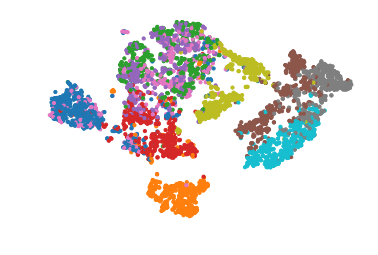

In [34]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1],
            c=y_valid, s=10, cmap='tab10')
plt.axis('off')
plt.show()

Let's make this diagram a bit prettier:

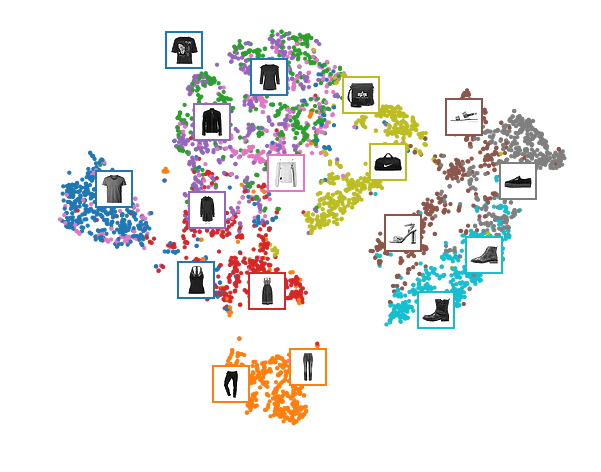

In [35]:
plt.figure(figsize=(10, 8))

cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1],
            c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])

for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: #if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap='binary'),
            position, bboxprops={'edgecolor': cmap(y_valid[index]), 
                                 'lw': 2})
        plt.gca().add_artist(imagebox)
        
plt.axis('off')
plt.show()

## Unsupervised Pretraining using Stacked Autoencoders

### Tying Weights:

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [36]:
class DenseTranspose(keras.layers.Layer):
    
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias',
                                      shape=[self.dense.input_shape[-1]],
                                      initializer='zeros')
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [37]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [38]:
dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [39]:
tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

In [40]:
tied_ae.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(lr=1.5),
                metrics=[rounder_accuracy])

In [41]:
history = tied_ae.fit(X_train, X_train,
                      epochs=10,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 89us/sample - loss: 0.3213 - rounder_accuracy: 0.8996 - val_loss: 0.3038 - val_rounder_accuracy: 0.9154
Epoch 2/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.2967 - rounder_accuracy: 0.9216 - val_loss: 0.2931 - val_rounder_accuracy: 0.9268
Epoch 3/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.2916 - rounder_accuracy: 0.9263 - val_loss: 0.2929 - val_rounder_accuracy: 0.9254
Epoch 4/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.2889 - rounder_accuracy: 0.9287 - val_loss: 0.2905 - val_rounder_accuracy: 0.9316
Epoch 5/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2871 - rounder_accuracy: 0.9303 - val_loss: 0.2917 - val_rounder_accuracy: 0.9307
Epoch 6/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2858 - rounder_accuracy: 0.9316 - val_loss:

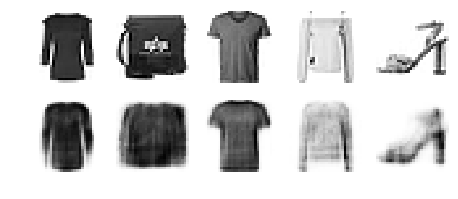

In [42]:
show_recons(tied_ae)
plt.show()

### Training one Autoencoder at a Time:

In [43]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)

enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), 
    output_activation="sigmoid",
    metrics=[rounder_accuracy])

enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", 
    keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3446 - rounder_accuracy: 0.8874 - val_loss: 0.3122 - val_rounder_accuracy: 0.9147
Epoch 2/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.3039 - rounder_accuracy: 0.9204 - val_loss: 0.3006 - val_rounder_accuracy: 0.9241
Epoch 3/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2949 - rounder_accuracy: 0.9286 - val_loss: 0.2933 - val_rounder_accuracy: 0.9319
Epoch 4/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.2890 - rounder_accuracy: 0.9343 - val_loss: 0.2887 - val_rounder_accuracy: 0.9362
Epoch 5/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.2853 - rounder_accuracy: 0.9379 - val_loss: 0.2856 - val_rounder_accuracy: 0.9390
Epoch 6/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.2826 - rounder_accuracy: 0.9404 - val_loss:

In [46]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

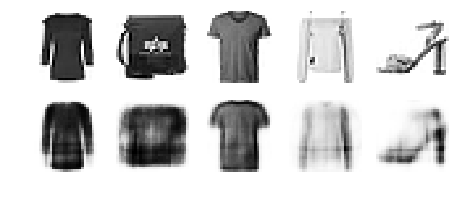

In [48]:
show_recons(stacked_ae_1_by_1)
plt.show()

In [49]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), 
                          metrics=[rounder_accuracy])

history = stacked_ae_1_by_1.fit(X_train, X_train, 
                                epochs=10,
                                validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.2853 - rounder_accuracy: 0.9359 - val_loss: 0.2868 - val_rounder_accuracy: 0.9361
Epoch 2/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.2849 - rounder_accuracy: 0.9363 - val_loss: 0.2866 - val_rounder_accuracy: 0.9364
Epoch 3/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2847 - rounder_accuracy: 0.9365 - val_loss: 0.2864 - val_rounder_accuracy: 0.9362
Epoch 4/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2846 - rounder_accuracy: 0.9366 - val_loss: 0.2863 - val_rounder_accuracy: 0.9367
Epoch 5/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2844 - rounder_accuracy: 0.9368 - val_loss: 0.2862 - val_rounder_accuracy: 0.9369
Epoch 6/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2843 - rounder_accuracy: 0.9369 - val_loss:

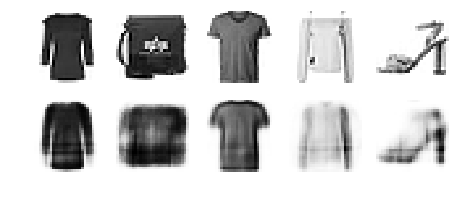

In [50]:
show_recons(stacked_ae_1_by_1)
plt.show()

## Convolutional Autoencoders

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders):

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, 
                        kernel_size=3,
                        padding='SAME',
                        activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32,
                        kernel_size=3,
                        padding='SAME',
                        activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64,
                        kernel_size=3,
                        padding='SAME',
                        activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

In [55]:
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32,
                                 kernel_size=3,
                                 strides=2,
                                 padding='VALID',
                                 activation='selu',
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16,
                                 kernel_size=3,
                                 strides=2,
                                 padding='SAME',
                                 activation='selu'),
    keras.layers.Conv2DTranspose(1,
                                 kernel_size=3,
                                 strides=2,
                                 padding='SAME',
                                 activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [56]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [57]:
conv_ae.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(lr=1.5),
                metrics=[rounder_accuracy])

In [58]:
history = conv_ae.fit(X_train, X_train,
                      epochs=5,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 41s 738us/sample - loss: 0.2973 - rounder_accuracy: 0.9229 - val_loss: 0.2807 - val_rounder_accuracy: 0.9347
Epoch 2/5
55000/55000 [==============================] - 41s 744us/sample - loss: 0.2732 - rounder_accuracy: 0.9438 - val_loss: 0.2707 - val_rounder_accuracy: 0.9486
Epoch 3/5
55000/55000 [==============================] - 37s 679us/sample - loss: 0.2689 - rounder_accuracy: 0.9482 - val_loss: 0.2698 - val_rounder_accuracy: 0.9453
Epoch 4/5
55000/55000 [==============================] - 41s 742us/sample - loss: 0.2665 - rounder_accuracy: 0.9507 - val_loss: 0.2661 - val_rounder_accuracy: 0.9520
Epoch 5/5
55000/55000 [==============================] - 40s 736us/sample - loss: 0.2648 - rounder_accuracy: 0.9524 - val_loss: 0.2653 - val_rounder_accuracy: 0.9533


In [59]:
conv_encoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

In [60]:
conv_decoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28)            0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


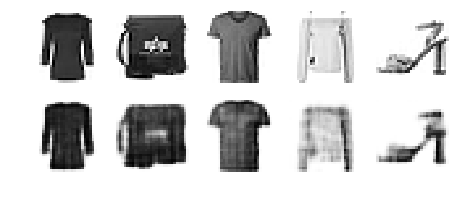

In [61]:
show_recons(conv_ae)
plt.show()

## Recurrent Autoencoders

In [62]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True,
                      input_shape=[28, 28]),
    keras.layers.LSTM(30)
])

In [63]:
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28,
                                                    activation='sigmoid'))
])

In [64]:
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

In [65]:
recurrent_ae.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(lr=0.1),
                     metrics=[rounder_accuracy])

In [66]:
history = recurrent_ae.fit(X_train, X_train,
                           epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.5191 - rounder_accuracy: 0.7485 - val_loss: 0.4576 - val_rounder_accuracy: 0.8103
Epoch 2/10
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.4050 - rounder_accuracy: 0.8435 - val_loss: 0.3802 - val_rounder_accuracy: 0.8631
Epoch 3/10
55000/55000 [==============================] - 72s 1ms/sample - loss: 0.3655 - rounder_accuracy: 0.8710 - val_loss: 0.3566 - val_rounder_accuracy: 0.8791
Epoch 4/10
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.3508 - rounder_accuracy: 0.8808 - val_loss: 0.3458 - val_rounder_accuracy: 0.8822
Epoch 5/10
55000/55000 [==============================] - 69s 1ms/sample - loss: 0.3405 - rounder_accuracy: 0.8874 - val_loss: 0.3368 - val_rounder_accuracy: 0.8920
Epoch 6/10
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.3335 - rounder_accuracy: 0.8922 - val_loss:

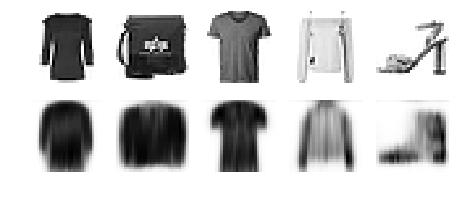

In [67]:
show_recons(recurrent_ae)
plt.show()

## Stacked Denoising Autoencoders

Using Gaussian noise:

In [68]:
tf.randomom.set_seed(42)
np.random.seed(42)

In [70]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

In [71]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu',
                       input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [72]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])

In [73]:
denoising_ae.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounder_accuracy])

In [74]:
history = denoising_ae.fit(X_train, X_train,
                           epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.3508 - rounder_accuracy: 0.8768 - val_loss: 0.3221 - val_rounder_accuracy: 0.9071
Epoch 2/10
55000/55000 [==============================] - 5s 89us/sample - loss: 0.3125 - rounder_accuracy: 0.9093 - val_loss: 0.3078 - val_rounder_accuracy: 0.9147
Epoch 3/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.3062 - rounder_accuracy: 0.9148 - val_loss: 0.3044 - val_rounder_accuracy: 0.9168
Epoch 4/10
55000/55000 [==============================] - 6s 112us/sample - loss: 0.3024 - rounder_accuracy: 0.9181 - val_loss: 0.3021 - val_rounder_accuracy: 0.9162
Epoch 5/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.2998 - rounder_accuracy: 0.9203 - val_loss: 0.2978 - val_rounder_accuracy: 0.9248
Epoch 6/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.2978 - rounder_accuracy: 0.9220 - val_los

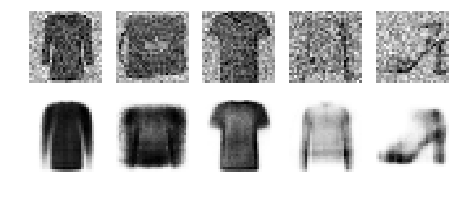

In [75]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_recons(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [76]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", 
                       input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounder_accuracy])

history = dropout_ae.fit(X_train, X_train, 
                         epochs=10,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 100us/sample - loss: 0.3564 - rounder_accuracy: 0.8713 - val_loss: 0.3195 - val_rounder_accuracy: 0.9036
Epoch 2/10
55000/55000 [==============================] - 5s 95us/sample - loss: 0.3183 - rounder_accuracy: 0.9032 - val_loss: 0.3111 - val_rounder_accuracy: 0.9118
Epoch 3/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.3129 - rounder_accuracy: 0.9073 - val_loss: 0.3076 - val_rounder_accuracy: 0.9131
Epoch 4/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.3091 - rounder_accuracy: 0.9104 - val_loss: 0.3036 - val_rounder_accuracy: 0.9183
Epoch 5/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3065 - rounder_accuracy: 0.9126 - val_loss: 0.3015 - val_rounder_accuracy: 0.9199
Epoch 6/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3047 - rounder_accuracy: 0.9141 - val_loss

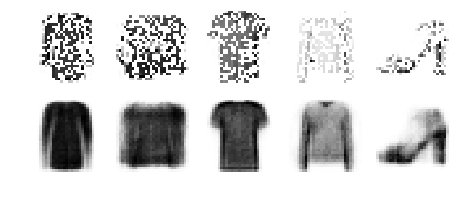

In [77]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_recons(dropout_ae, dropout(X_valid, training=True))

## Sparse Autoencoders

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [78]:
tf.random.set_seed(42)
np.random.seed(42)

In [79]:
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])

simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", 
                       input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])

In [81]:
simple_ae.compile(loss="binary_crossentropy", 
                  optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounder_accuracy])

history = simple_ae.fit(X_train, X_train, 
                        epochs=10,
                        validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.4331 - rounder_accuracy: 0.7944 - val_loss: 0.3778 - val_rounder_accuracy: 0.8507
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3610 - rounder_accuracy: 0.8671 - val_loss: 0.3510 - val_rounder_accuracy: 0.8769
Epoch 3/10
55000/55000 [==============================] - 6s 100us/sample - loss: 0.3405 - rounder_accuracy: 0.8858 - val_loss: 0.3359 - val_rounder_accuracy: 0.8894
Epoch 4/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.3276 - rounder_accuracy: 0.8967 - val_loss: 0.3248 - val_rounder_accuracy: 0.8994
Epoch 5/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.3206 - rounder_accuracy: 0.9017 - val_loss: 0.3206 - val_rounder_accuracy: 0.9020
Epoch 6/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.3172 - rounder_accuracy: 0.9042 - val_loss

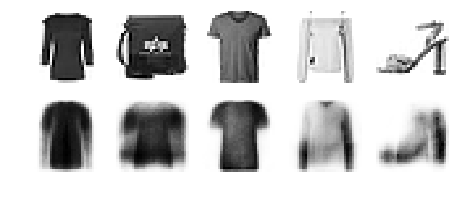

In [82]:
show_recons(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [83]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [84]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

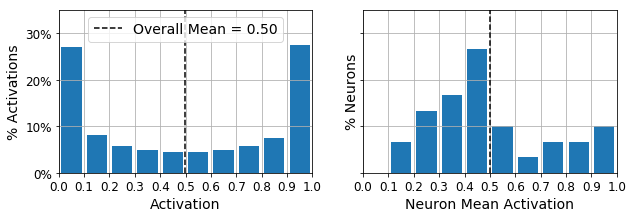

In [85]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", 
                       input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="binary_crossentropy", 
                     optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounder_accuracy])

history = sparse_l1_ae.fit(X_train, X_train, 
                           epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
show_recons(sparse_l1_ae)

In [ ]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

[0, 1, 0, 0.95]

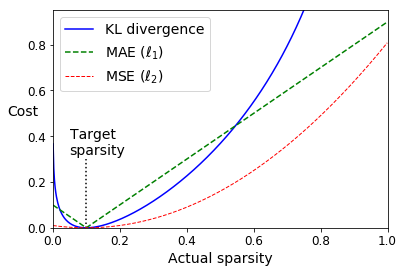

In [88]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

mse = (p - q)**2
mae = np.abs(p - q)

plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [89]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
        
    def call(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [90]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='sigmoid',
                       activity_regularizer=kld_reg)
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu',
                       input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [ ]:
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_ae.compile(loss="binary_crossentropy", 
                     optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])

history = sparse_kl_ae.fit(X_train, X_train, 
                           epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(sparse_kl_ae)

In [ ]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

## Variational Autoencoders

In [92]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [93]:
tf.random.set_seed(42)
np.random.seed(42)

In [94]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)

codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs],
    outputs=[codings_mean, codings_log_var, codings])

In [95]:
decoder_inputs = keras.layers.Input(shape=[codings_size])

x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)

outputs = keras.layers.Reshape([28, 28])(x)

variational_decoder = keras.models.Model(inputs=[decoder_inputs], 
                                         outputs=[outputs])

In [97]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

variational_ae.add_loss(K.mean(latent_loss) / 784.)

variational_ae.compile(loss="binary_crossentropy", 
                       optimizer="rmsprop", 
                       metrics=[rounder_accuracy])

history = variational_ae.fit(X_train, X_train, 
                             epochs=25, 
                             batch_size=128,
                             validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3911 - rounder_accuracy: 0.8587 - val_loss: 0.3612 - val_rounder_accuracy: 0.8815
Epoch 2/25
55000/55000 [==============================] - 4s 82us/sample - loss: 0.3433 - rounder_accuracy: 0.8971 - val_loss: 0.3393 - val_rounder_accuracy: 0.8980
Epoch 3/25
55000/55000 [==============================] - 4s 82us/sample - loss: 0.3328 - rounder_accuracy: 0.9049 - val_loss: 0.3381 - val_rounder_accuracy: 0.9032
Epoch 4/25
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3277 - rounder_accuracy: 0.9092 - val_loss: 0.3246 - val_rounder_accuracy: 0.9132
Epoch 5/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3244 - rounder_accuracy: 0.9119 - val_loss: 0.3252 - val_rounder_accuracy: 0.9092
Epoch 6/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3221 - rounder_accuracy: 0.9136 - val_loss:

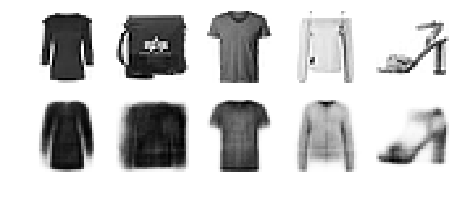

In [98]:
show_recons(variational_ae)
plt.show()

## Generating Fashion MNIST Images

In [99]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(image, cmap='binary')
        plt.axis('off')

Let's generate a few random codings, decode them and plot the resulting images:

Saving figure vae_generated_images_plot


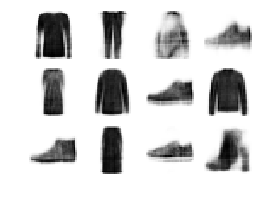

In [100]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Now let's perform semantic interpolation between these images:

Saving figure semantic_interpolation_plot


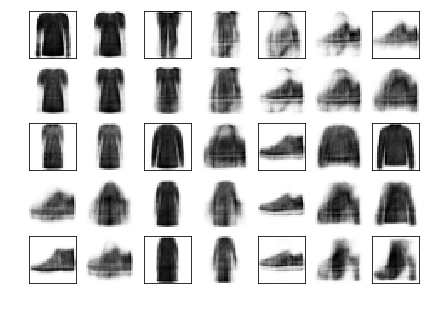

In [101]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

## Generative Adversarial Networks

In [102]:
np.random.seed(42)
tf.random.set_seed(42)

In [103]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu',
                       input_shape=[codings_size]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [104]:
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [105]:
gan = keras.models.Sequential([generator, discriminator])

In [106]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer='rmsprop')

discriminator.trainable = False

In [107]:
gan.compile(loss='binary_crossentropy',
            optimizer='rmsprop')

In [108]:
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [109]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))
        for X_batch in dataset:
            # Phase 1: training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Phase 2: training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

Epoch 1/1


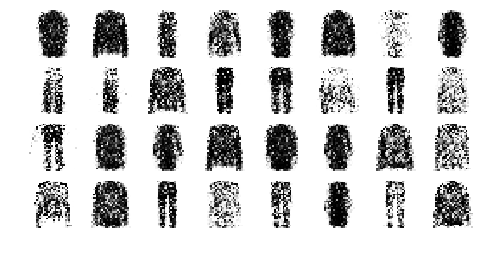

In [110]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Saving figure gan_generated_images_plot


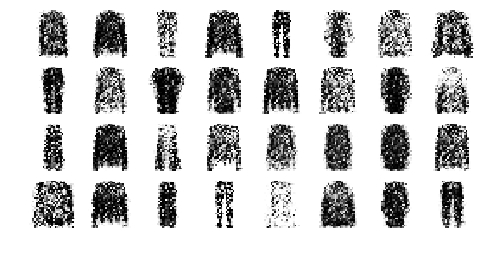

In [111]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

## Deep Convolutional GANs

In [112]:
tf.random.set_seed(42)
np.random.seed(42)

In [113]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128,
                       input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5,
                                 strides=2,
                                 padding='SAME',
                                 activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5,
                                 strides=2,
                                 padding='SAME',
                                 activation='tanh')
])

In [115]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5,
                        strides=2, 
                        padding='SAME',
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5,
                        strides=2, 
                        padding='SAME',
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [116]:
gan = keras.models.Sequential([generator, discriminator])

In [117]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [118]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. 
# reshape and rescale

In [119]:
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/2


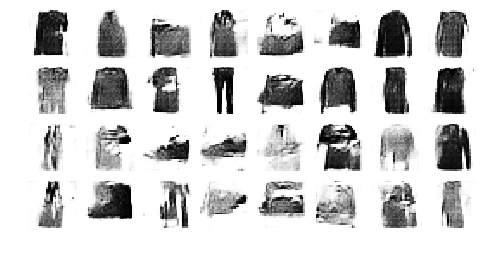

Epoch 2/2


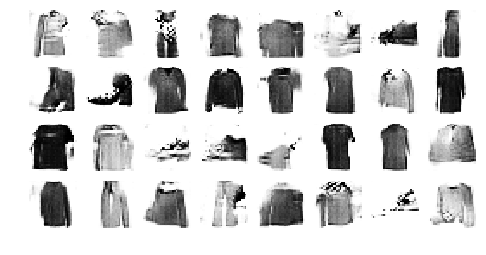

In [122]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=2)

Saving figure dcgan_generated_images_plot


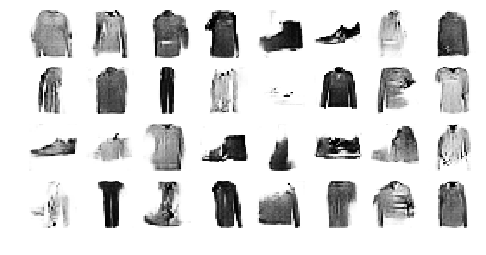

In [123]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)